# Mount the drive

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
!mkdir -p drive
!google-drive-ocamlfuse drive

In [5]:
!ls drive

Colab Notebooks  fingerdataset8000.zip	models	   Pointer.ipynb
data.zip	 Getting started	model.zip  Untitled0.ipynb


In [0]:
!unzip drive/fingerdataset8000.zip 

# Load the labels and images

In [0]:
import numpy as np 
import cv2
import os 
import matplotlib.pyplot as plt

In [0]:
base = 'fingerdataset8000/'
files = os.listdir(base)

In [0]:
labels = {}
with open(base+'labels.txt') as f:
    lines = f.readlines()
    for line in lines:
        data = line.strip('\n')
        data = data.split('\t')
        box  = [float(x) for x in data[1:3]]
        img = cv2.imread(base+data[0])
        if img is None:
          continue
        labels[data[0]] = box
        

In [4]:
print(labels)

{'I_Chinesebook_8.png': [0.573438, 0.447917], 'I_Chinesebook_9.png': [0.565625, 0.433333], 'I_Chinesebook_10.png': [0.557813, 0.433333], 'I_Chinesebook_11.png': [0.546875, 0.4375], 'I_Chinesebook_12.png': [0.535937, 0.433333], 'I_Chinesebook_13.png': [0.528125, 0.429167], 'I_Chinesebook_14.png': [0.515625, 0.414583], 'I_Chinesebook_15.png': [0.496875, 0.397917], 'I_Chinesebook_16.png': [0.471875, 0.377083], 'I_Chinesebook_17.png': [0.446875, 0.339583], 'I_Chinesebook_28.png': [0.3, 0.485417], 'I_Chinesebook_29.png': [0.301562, 0.514583], 'I_Chinesebook_38.png': [0.43125, 0.425], 'I_Chinesebook_39.png': [0.407813, 0.408333], 'I_Chinesebook_44.png': [0.342187, 0.4], 'I_Chinesebook_45.png': [0.332812, 0.41875], 'I_Chinesebook_46.png': [0.31875, 0.460417], 'I_Chinesebook_47.png': [0.321875, 0.45625], 'I_Chinesebook_48.png': [0.31875, 0.483333], 'I_Chinesebook_49.png': [0.31875, 0.5125], 'I_Chinesebook_50.png': [0.33125, 0.55], 'I_Chinesebook_51.png': [0.342187, 0.577083], 'I_Chinesebook_52

# Draw Annotations

In [0]:
def draw_annot(img, box):
    W,H,_ = img.shape 
    x = box[0]*H
    y = box[1]*W
    
    output = cv2.circle(img, (int(x),int(y)), 5, (255, 0, 0), -1)
    plt.plot([int(x)],[int(y)], marker='o', markersize=10, color="red")
    plt.imshow(img[:,:,::-1])
    plt.show()
  

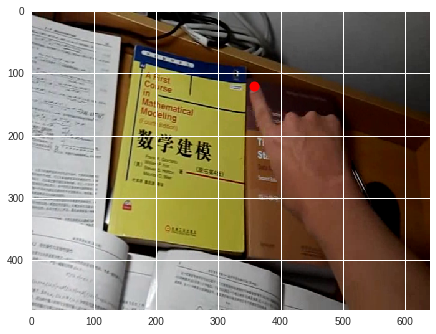

In [6]:
img_id = np.random.choice(list(labels.keys()))
img = cv2.imread(base+img_id)
box = labels[img_id]
draw_annot(img, box)

# Create Training and Validation

In [0]:
def preprocess_input(img):
  w,h   = 256, 256 
  img = cv2.resize(img, (w, h))
  img = img/255. 
  return img 

def image_generator(input_ids, batch_size = 64):
    while True:
          # Select files (paths/indices) for the batch
          batch_paths = np.random.choice(a = input_ids, 
                                         size = batch_size)
          batch_input = []
          batch_output = [] 
          
          # Read in each input, perform preprocessing and get labels

          for input_id in batch_paths:
              input = cv2.imread(base+input_id)
              output = labels[input_id]
              input = preprocess_input(input)
              batch_input += [ input ]
              batch_output += [ output ]

          # Return a tuple of (input,output) to feed the network

          batch_x = np.array( batch_input )
          batch_y = np.array( batch_output )
        
          yield( batch_x, batch_y )

In [0]:
from random import shuffle
batch_size = 16 

img_ids = list(labels.keys())
shuffle(img_ids)
split = int(0.8 * len(img_ids))

train_ids = img_ids[0:split]
valid_ids = img_ids[split:]

train_generator = image_generator(train_ids, batch_size = batch_size)
valid_generator = image_generator(valid_ids, batch_size = batch_size)

In [0]:
x, y = next(train_generator)

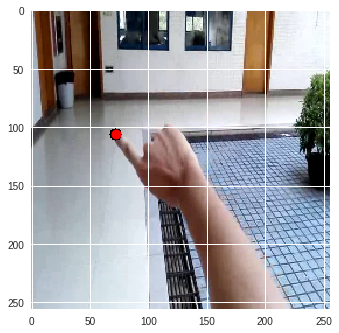

In [10]:
draw_annot(x[0], y[0])

In [11]:
print('Length of training data ', len(train_ids))
print('Length of validation data', len(valid_ids))

Length of training data  3864
Length of validation data 966


# Create Model 

In [12]:
import keras
from keras import layers
model = keras.Sequential()

model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=[256, 256, 3], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(2)) 
# Train model
model.compile(loss='mean_squared_error', optimizer='adam')

Using TensorFlow backend.


# Training

In [13]:
train_steps = len(train_ids) // batch_size
valid_steps = len(valid_ids) // batch_size 
model.fit_generator(train_generator, validation_data=valid_generator, epochs=5, 
                    steps_per_epoch = train_steps , validation_steps = valid_steps)

Epoch 1/5
241/241 [==============================] - 54s 225ms/step - loss: 0.0584 - val_loss: 0.0057
Epoch 2/5
241/241 [==============================] - 50s 209ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 3/5
241/241 [==============================] - 50s 209ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 4/5
241/241 [==============================] - 51s 211ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 5/5
241/241 [==============================] - 51s 210ms/step - loss: 8.1322e-04 - val_loss: 0.0012


# Validation

[0.1778285  0.31691894]


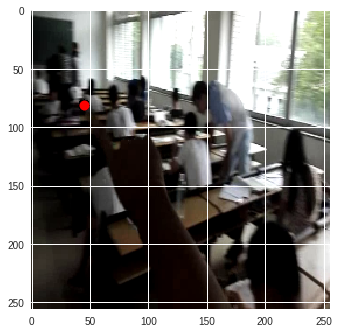

[0.57479626 0.46627015]


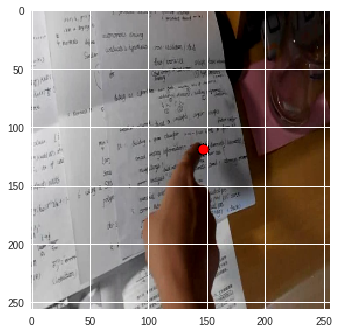

[0.39657623 0.24803443]


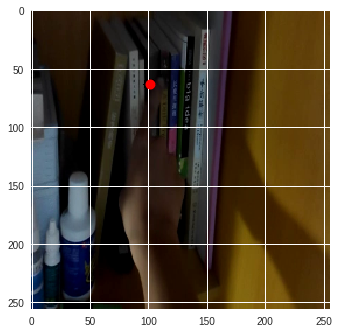

[0.5339343  0.19910945]


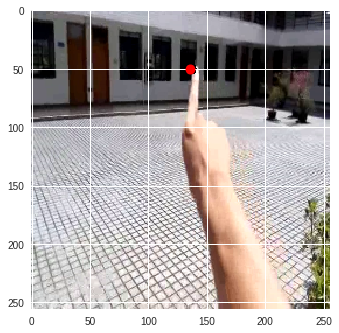

[0.47247294 0.2849827 ]


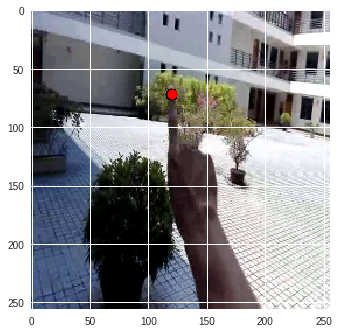

[0.43275297 0.5521219 ]


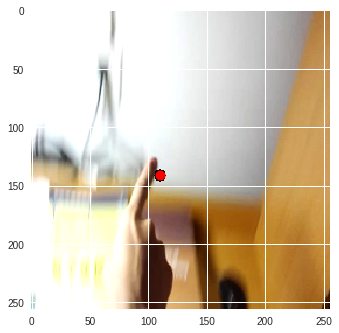

[0.5762958  0.28606954]


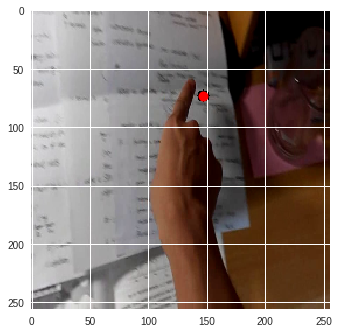

[0.40624112 0.25062105]


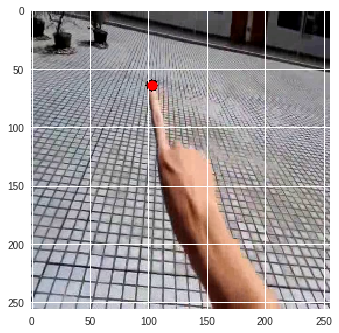

[0.56576204 0.21556684]


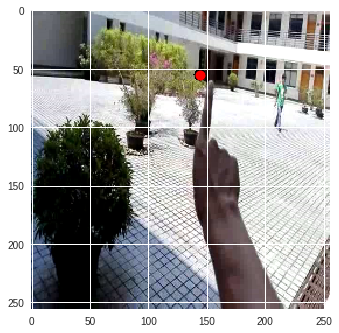

[0.40820092 0.38463217]


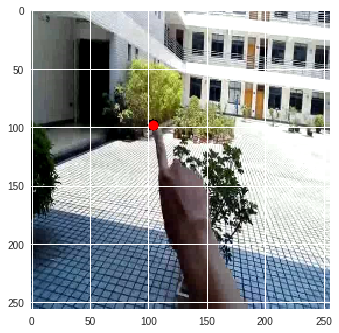

[0.55045307 0.1724281 ]


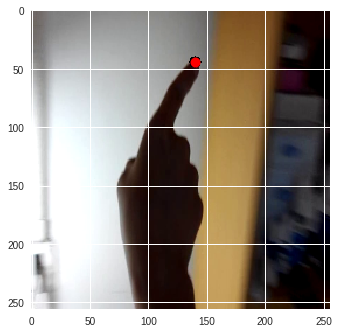

[0.32340148 0.14179417]


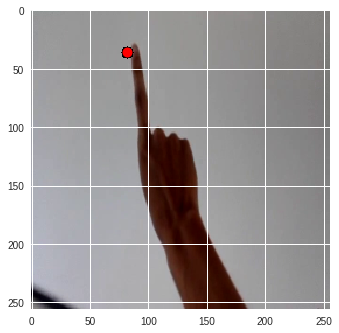

[0.20520194 0.39603418]


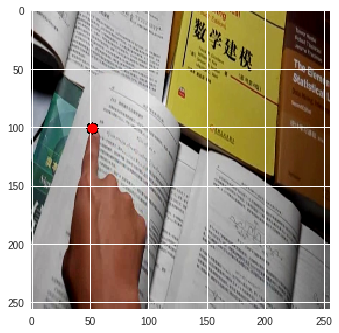

[0.28672075 0.23664868]


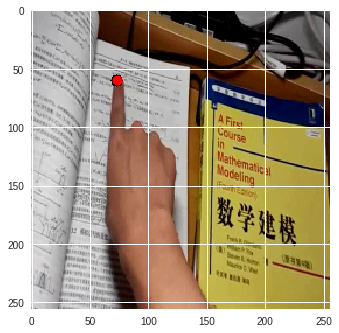

[0.42151985 0.2855364 ]


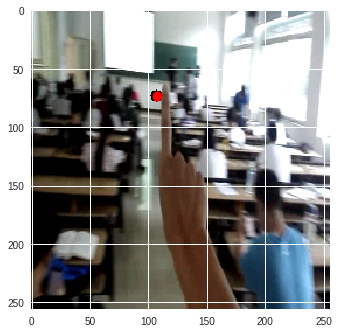

[0.5087459  0.12915596]


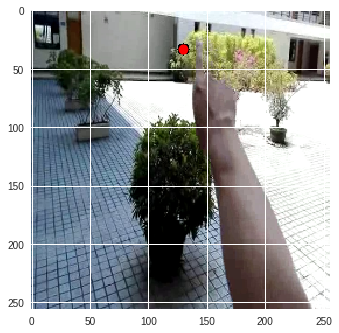

[0.33957517 0.298791  ]


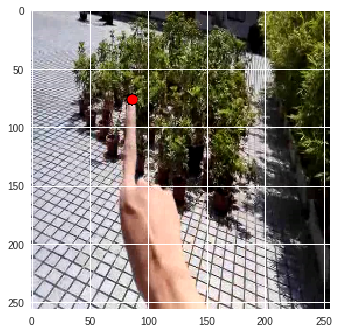

[0.4295998  0.34415996]


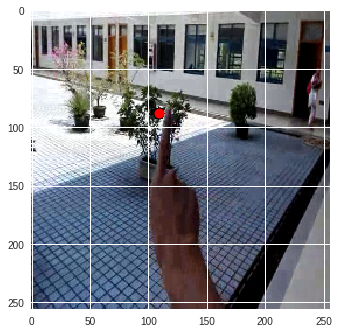

[0.50154626 0.4143497 ]


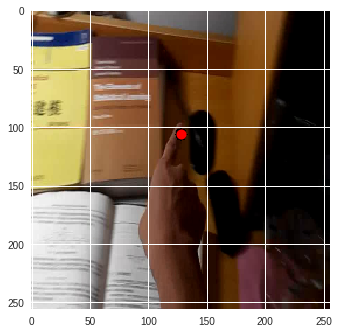

[0.3998743 0.6580235]


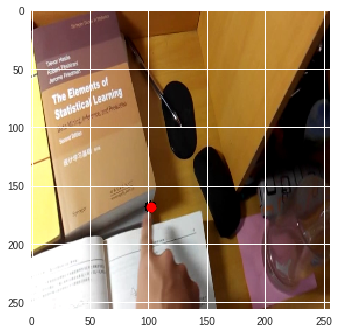

[0.36127037 0.32414708]


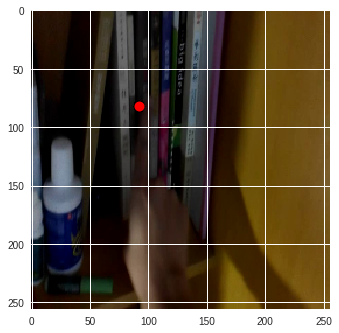

[0.50014555 0.4171572 ]


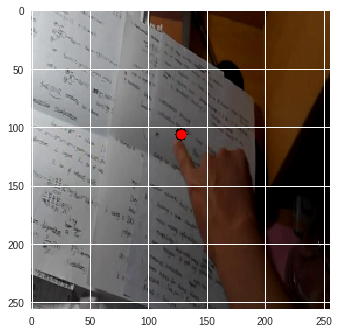

[0.46374118 0.2707188 ]


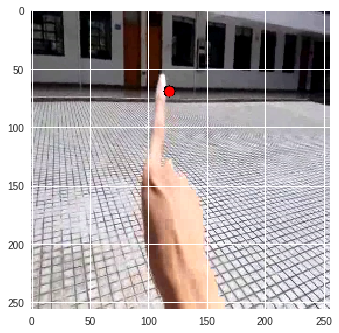

[0.20352684 0.43157202]


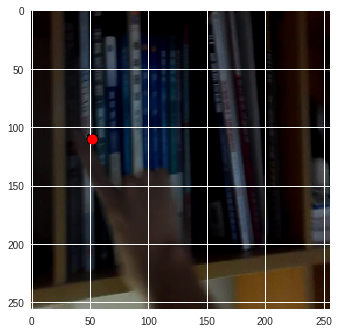

[0.6582703  0.35077143]


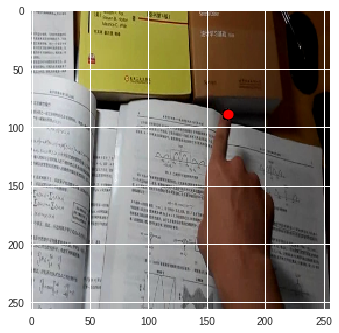

[0.32457477 0.22223444]


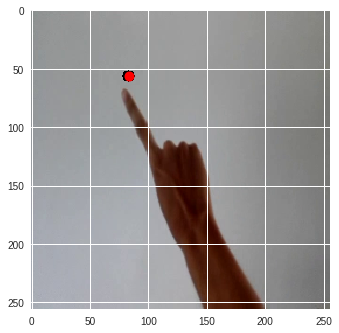

[0.5087459  0.12915596]


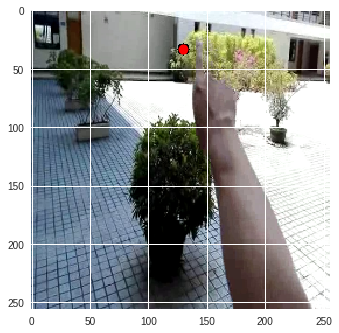

[0.4554624  0.22496921]


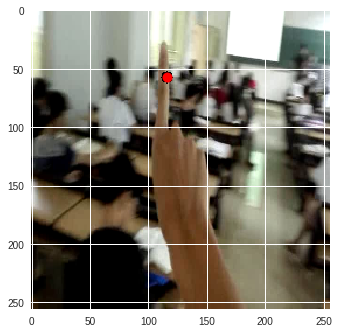

[0.22758768 0.44003078]


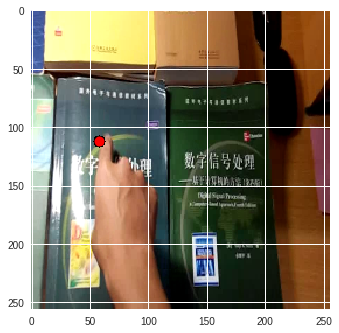

[0.38408777 0.2050755 ]


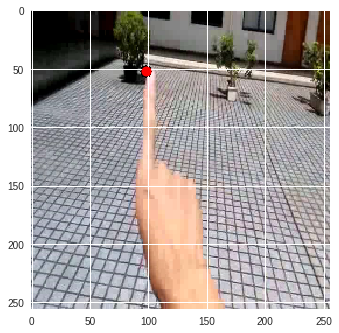

[0.56056225 0.38230088]


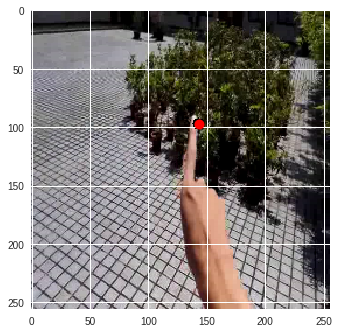

[0.34576043 0.36984682]


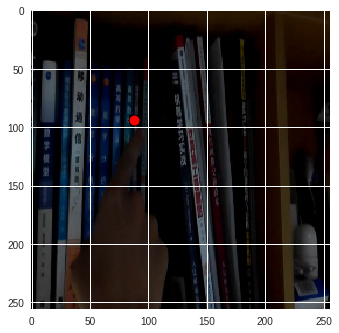

[0.52502966 0.31367174]


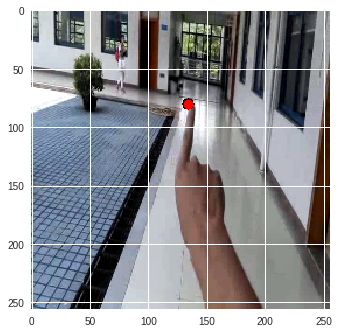

[0.32707953 0.22230539]


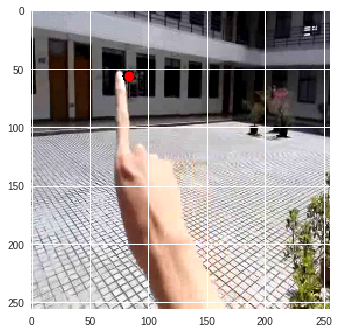

[0.4361835 0.2542678]


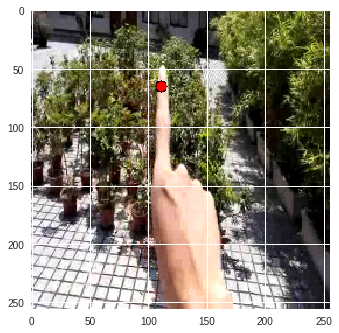

[0.23550919 0.29299542]


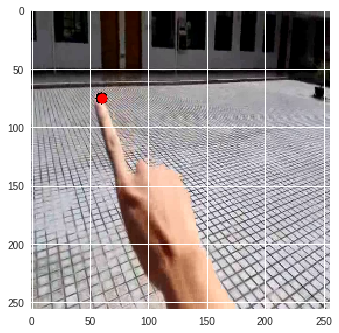

[0.4426327  0.33856094]


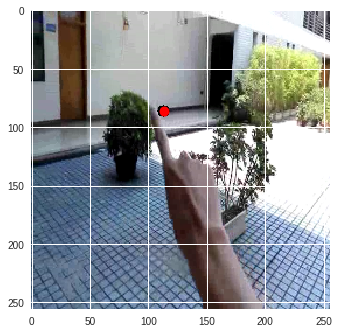

[0.3085973  0.26906773]


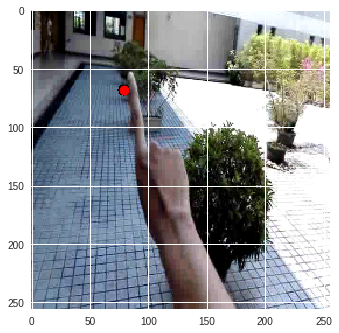

[0.41009825 0.43077698]


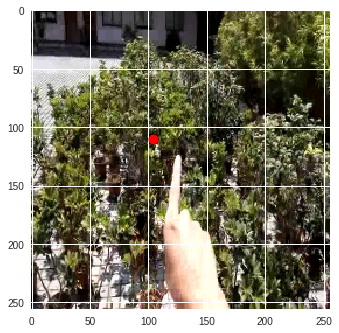

[0.5121874  0.25052577]


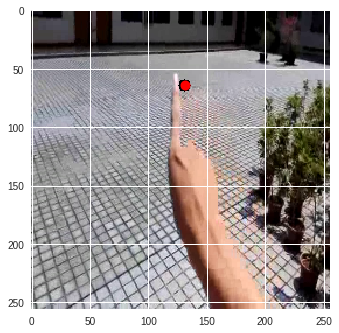

[0.5180966  0.29780942]


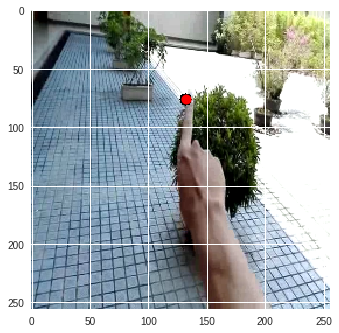

[0.2958245  0.33361557]


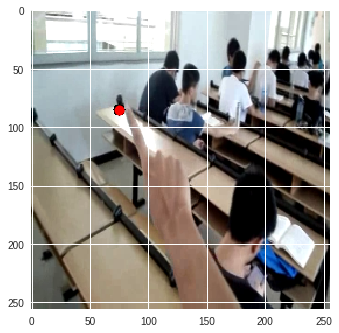

[0.45606345 0.31018892]


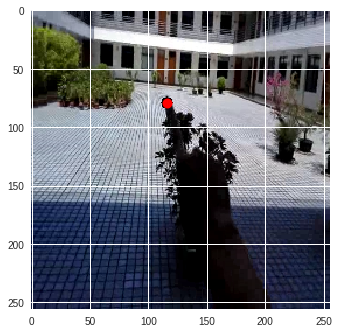

[0.29638875 0.26234737]


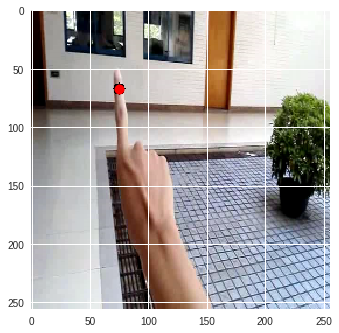

[0.4001021 0.227282 ]


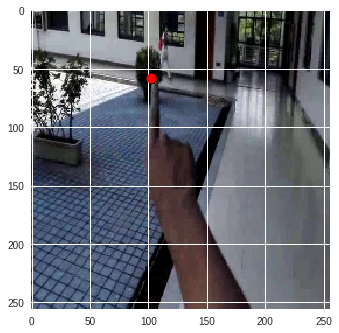

[0.30730876 0.25709844]


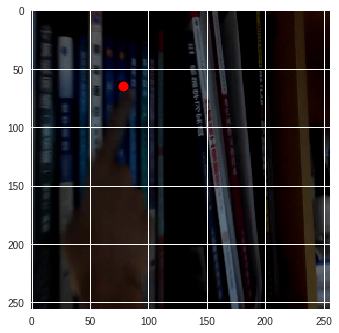

[0.54317766 0.35664842]


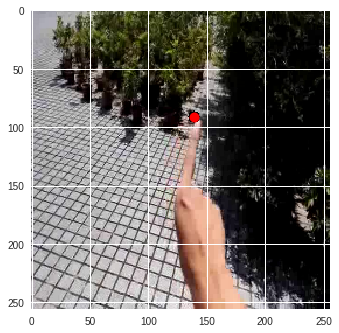

[0.41046372 0.22720185]


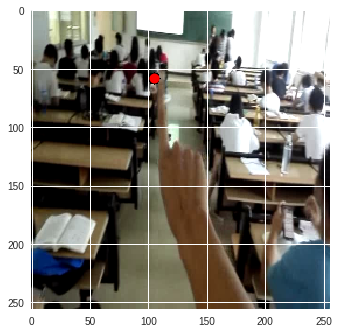

[0.34570658 0.28988513]


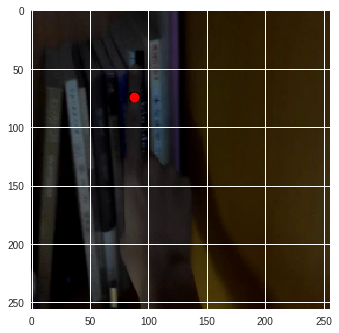

[0.4001021 0.227282 ]


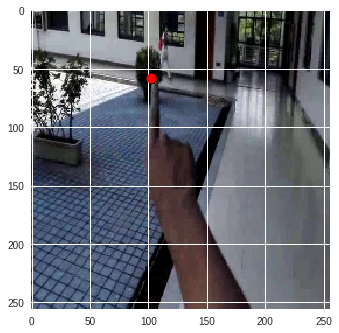

[0.37421352 0.21705061]


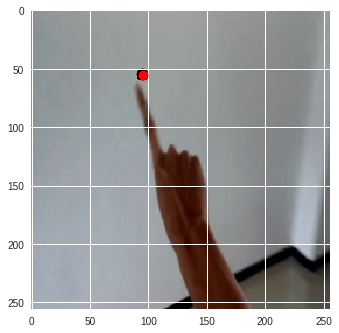

In [15]:

for i, (x, _) in enumerate(valid_generator):
    sample = x[0]
    pred = model.predict(np.expand_dims(sample,0))
    print(pred[0])
    draw_annot(sample, pred[0])
    plt.ioff()
    if i == 50:
      break
    